In [1]:
import os
from pydantic import Field, BaseModel
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
from monai.networks.nets import UNet

from ketsu.utils import fix_global_seed
from ketsu.datasets import ConjDataset
from ketsu.seg import ConjConfig, ConjModule, CustomEarlyStopping

fix_global_seed(0)
pl.seed_everything(0)
torch.set_float32_matmul_precision('medium')
device = 'cuda'

Seed set to 0


In [2]:
# from ketsu.main import CLI
# cli = CLI()
# a = CLI.TrainArgs(
#     experiment_name='base'
# )
# cli.run_train(a)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


lr=0.0001 batch_size=5 plateau=False with_vessel=False arch_name='albun' size=512


Testing: |                                                                                                  | …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9314316511154175     │
│         test_jac          │    0.8510950803756714     │
│         test_loss         │    0.22849920392036438    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22849920392036438, 'test_acc': 0.9314316511154175, 'test_jac': 0.8510950803756714}]
[233368  88359  87873]
[241847  86597  81156]


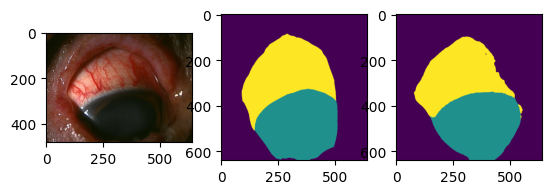

[313193  64848  31559]
[313483  62456  33661]


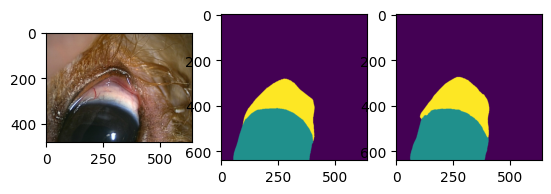

[170090  89167 150343]
[236677 105662  67261]


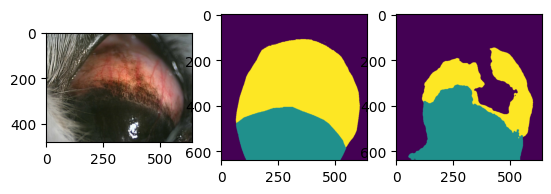

[114144 107787 187669]
[150178 109564 149858]


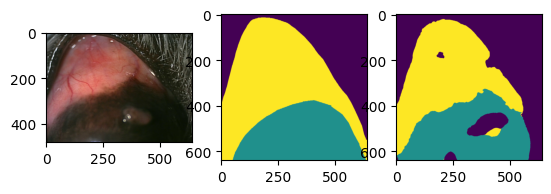

[299592  55612  54396]
[262869  82768  63963]


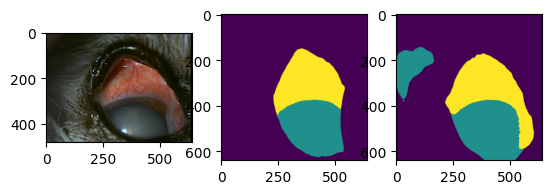

[289387  66704  53509]
[294130  66400  49070]


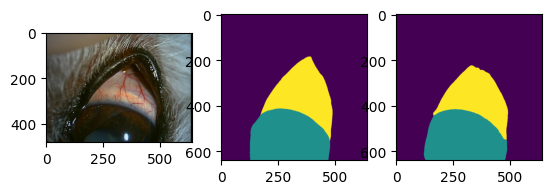

[216368 111499  81733]
[223362 116178  70060]


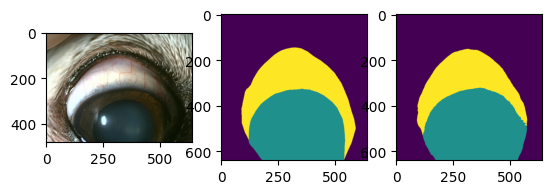

[234161  99147  76292]
[235848 100227  73525]


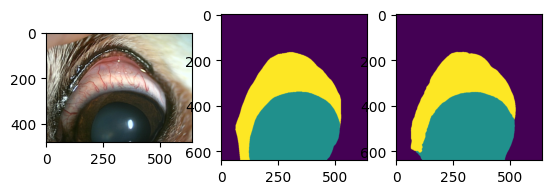

[202762 119289  87549]
[202811 117251  89538]


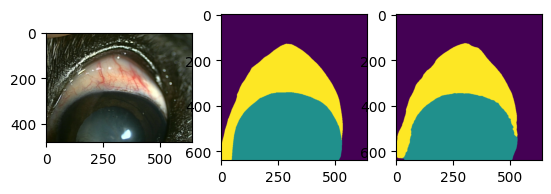

[202372 120465  86763]
[216366 116168  77066]


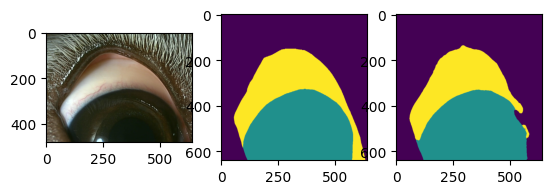

In [3]:
def evaluate(model, name, with_vessel):
    test_ds = ConjDataset(mode='val', size=640, with_vessel=with_vessel, augmentation=False, normalization=True)
    test_loader = DataLoader(test_ds, 10, num_workers=4)
    trainer = pl.Trainer(
        accelerator='gpu',
        logger=False,    
        devices=1,
    )
    
    model_dir = model
    if with_vessel:
        model_dir = 'v_' + model_dir
    module = ConjModule.load_from_checkpoint(
        f'./checkpoints/{model_dir}/{name}.ckpt',
    )
    print(module.config)
    print(trainer.test(module, test_loader))
    module = module.eval().to(device)
    
    for i in range(len(test_ds)):
        image, label = test_ds[i]
        x = image
        with torch.no_grad():
            x = x[None, ...].to(device)
            y = module(x)[0]
        y = y.detach().cpu().numpy().transpose(1, 2, 0).argmax(axis=-1)
        label = label.numpy()
        print(np.bincount(label.flatten(), minlength=module.num_classes))
        print(np.bincount(y.flatten(), minlength=module.num_classes))
        
        plt.subplot(1, 3, 1)
        plt.imshow(test_ds.images[i])
        plt.subplot(1, 3, 2)
        plt.imshow(label, vmin=0, vmax=module.num_classes-1)
        plt.subplot(1, 3, 3)
        plt.imshow(y, vmin=0, vmax=module.num_classes-1)
        plt.show()


evaluate('albun', 'base', with_vessel=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


lr=0.0001 batch_size=5 plateau=False with_vessel=True arch_name='albun' size=512


Testing: |                                                                                                  | …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.939038097858429     │
│         test_jac          │    0.6534442901611328     │
│         test_loss         │    0.2245093584060669     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2245093584060669, 'test_acc': 0.939038097858429, 'test_jac': 0.6534442901611328}]
[233368  88359  71126  16747]
[229687  79939  99974      0]


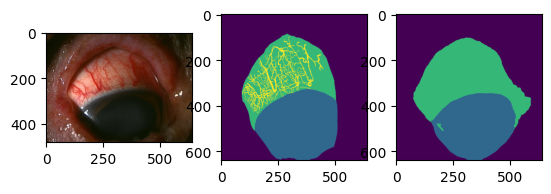

[313193  64848  28919   2640]
[314150  61979  33471      0]


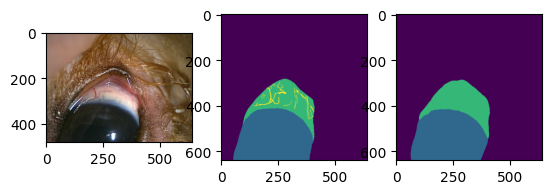

[170090  89167 147557   2786]
[199878  89170 120552      0]


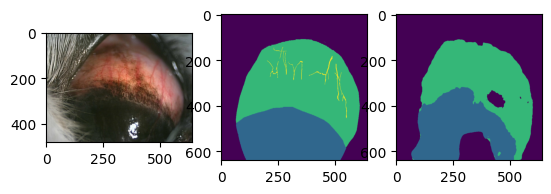

[114144 107787 179715   7954]
[133252 117096 159252      0]


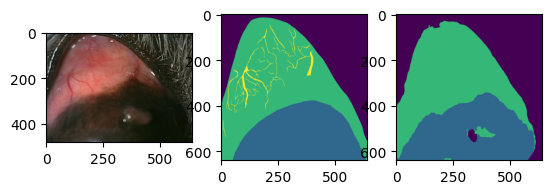

[299592  55612  48880   5516]
[284962  55636  69002      0]


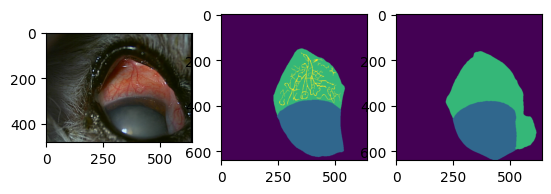

[289387  66704  47975   5534]
[294317  64874  50409      0]


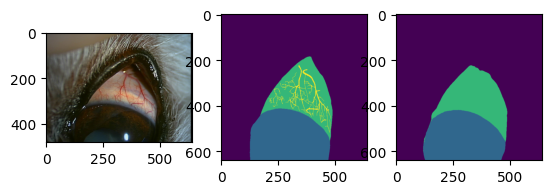

[216368 111499  81733      0]
[220677 110960  77963      0]


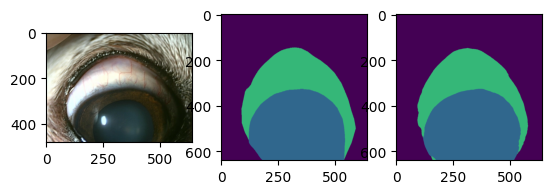

[234161  99147  76292      0]
[234539  96637  78424      0]


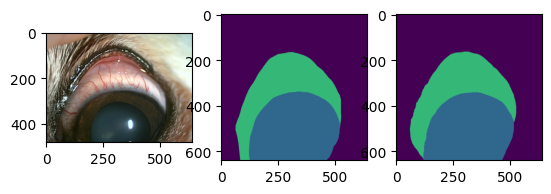

[202762 119289  87549      0]
[202058 112993  94549      0]


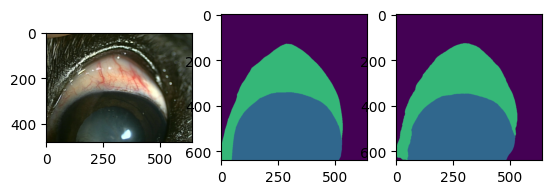

[202372 120465  86763      0]
[212822 113028  83750      0]


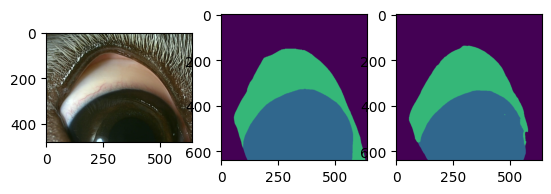

In [4]:
evaluate('albun', 'base', with_vessel=True)